In [1]:
import pandas as pd

aggregate_country_data = pd.read_csv('./2013.01.01-2015.04.30-aggregate-country-data.csv')
aggregate_country_data.head()

,Country,Users,New Users,Sessions,Bounce Rate,Pages / Session,Avg. Session Duration
0,United States,"434,944,680","427,058,422","1,202,850,944",59.86%,1.32,0:02:35
1,Canada,"58,957,484","56,514,054","160,809,556",58.49%,1.31,0:02:53
2,United Kingdom,"46,435,791","44,456,259","103,884,722",61.56%,1.35,0:02:25
3,Australia,"23,587,951","22,614,120","58,504,210",61.07%,1.39,0:02:51
4,Germany,"7,542,762","7,057,617","16,473,675",55.65%,1.38,0:03:13


In [3]:
daily_pageviews = pd.read_csv('./2013.01.01-2015.04.30-daily-pageviews.csv')
daily_pageviews.head()

,Day Index,Pageviews
0,1/1/13,"92,812"
1,1/2/13,"182,645"
2,1/3/13,"286,954"
3,1/4/13,"331,373"
4,1/5/13,"194,671"


In [4]:
# Extracting the number of US users from the aggregate country data
us_users = aggregate_country_data.loc[0, 'Users'].replace(',', '')

# Summing the daily pageviews (removing commas for the calculation)
total_pageviews = daily_pageviews['Pageviews'].str.replace(',', '').astype(int).sum()

us_users, total_pageviews

('434944680', 2351171402)

In [5]:
# Converting the 'Day Index' column to a datetime object
daily_pageviews['Day Index'] = pd.to_datetime(daily_pageviews['Day Index'], format='%m/%d/%y')

# Setting the 'Day Index' column as the index for time series analysis
daily_pageviews.set_index('Day Index', inplace=True)

# Converting the 'Pageviews' column to an integer type
daily_pageviews['Pageviews'] = daily_pageviews['Pageviews'].str.replace(',', '').astype(int)

# Resampling the daily data into monthly data
monthly_pageviews = daily_pageviews.resample('M').sum()
monthly_pageviews.head()

,Pageviews
Day Index,
2013-01-31,11509872
2013-02-28,20013973
2013-03-31,25411704
2013-04-30,28910253
2013-05-31,54494358


In [7]:
# Calculating the total users from all countries
total_users_all_countries = aggregate_country_data['Users'].str.replace(',', '').astype(int).sum()

# Calculating the proportion of US viewership
us_proportion = int(us_users) / total_users_all_countries

# Calculating the monthly US pageviews
monthly_us_pageviews = monthly_pageviews * us_proportion

# Saving the monthly US pageviews to a CSV file
output_file_path = './monthly_us_pageviews.csv'
monthly_us_pageviews.to_csv(output_file_path)

# Displaying the first few rows of the final result
monthly_us_pageviews.head(), output_file_path

(               Pageviews
 Day Index               
 2013-01-31  7.326481e+06
 2013-02-28  1.273967e+07
 2013-03-31  1.617554e+07
 2013-04-30  1.840250e+07
 2013-05-31  3.468778e+07,
 './monthly_us_pageviews_2.csv')

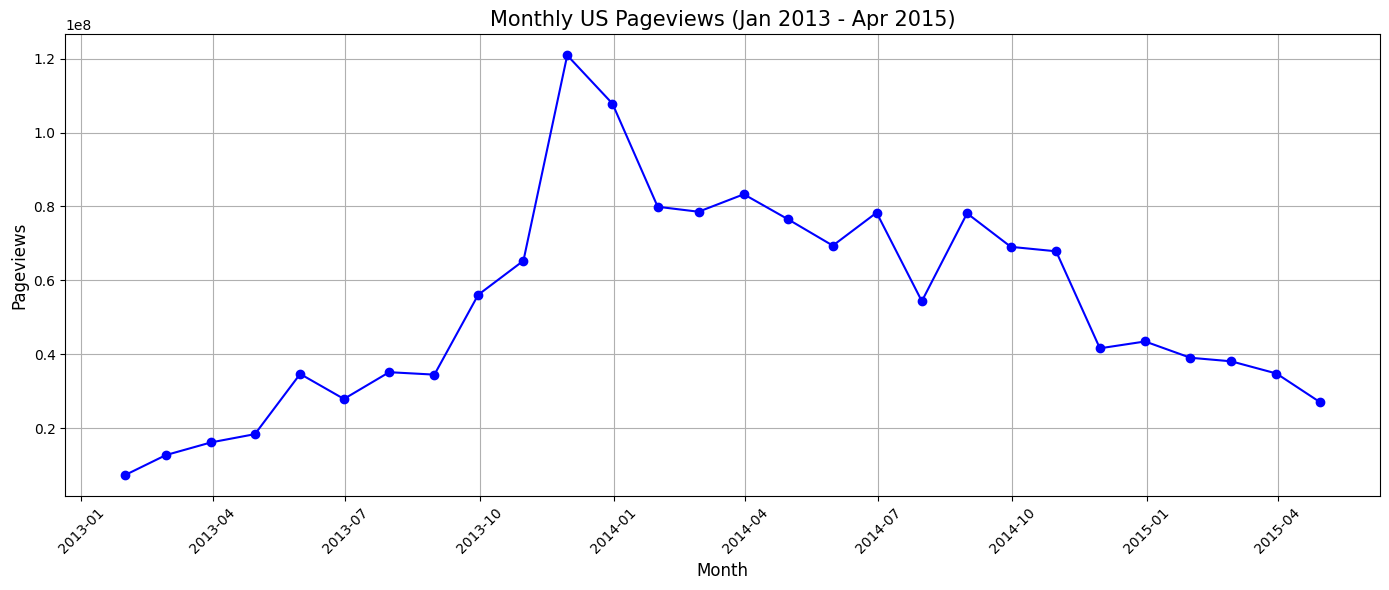

In [9]:
import matplotlib.pyplot as plt

# Plotting the monthly US pageviews
plt.figure(figsize=(14, 6))
plt.plot(monthly_us_pageviews.index, monthly_us_pageviews['Pageviews'], marker='o', linestyle='-', color='b')
plt.title('Monthly US Pageviews (Jan 2013 - Apr 2015)', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Pageviews', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Finding the month corresponding to the peak usage
peak_usage_month = monthly_us_pageviews['Pageviews'].idxmax()
peak_usage_month.strftime('%B %Y')

'November 2013'

In [1]:
import io
import pandas as pd
import numpy as np

# Function to parse tables
def parse_tables(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        tables = content.split("######### #########")
        parsed_tables = [pd.read_csv(io.StringIO(table), sep='|', skipinitialspace=True) for table in tables[1:] if table.strip() != '']
    return parsed_tables

logit_file_path = "./logit-analysis-of-american-adults-and-their-internet-and-blogging-practices.txt"

logit_tables = parse_tables(logit_file_path)
len(logit_tables)

# Function to correctly convert logit coefficients to percentages (with handling of NaN reference category)
def correct_logit_to_percentage(logit_table):
    coefficients = logit_table.iloc[:, 1]
    
    # Calculating the exponential of coefficients to get odds
    odds = coefficients.apply(lambda x: np.exp(x))
    # Calculating probabilities from odds
    probabilities = odds / (1 + odds.sum())
    # Converting probabilities to percentages
    percentages = probabilities * 100
    
    # Filling the missing value for the reference category
    percentages.fillna(100 - percentages.sum(), inplace=True)
    percentages.index = logit_table[logit_table.columns[0]]
    
    return percentages

education_percentages = correct_logit_to_percentage(logit_tables[0])
education_percentages

degree_index = community_type_index = marital_status_index = -1
for i, table in enumerate(logit_tables):
    if "Degree" in table.columns[0]:
        degree_index = i
    elif "Community Type" in table.columns[0]:
        community_type_index = i
    elif "Marital Status" in table.columns[0]:
        marital_status_index = i

degree_percentages = correct_logit_to_percentage(logit_tables[degree_index])
community_type_percentages = correct_logit_to_percentage(logit_tables[community_type_index])
marital_status_percentages = correct_logit_to_percentage(logit_tables[marital_status_index])

degree_percentages, community_type_percentages, marital_status_percentages

(Category: Marital Status 
 Married             20.479435
 Living Together     17.626813
 Divorced            17.803966
 Separated           15.478024
 Widowed             13.591182
 Single              15.020579
 Name: Model 1 - Internet User , dtype: float64,
 Category: Community Type 
 Suburban     36.039513
 Rural        28.634604
 Urban        35.325883
 Name: Model 1 - Internet User , dtype: float64,
 Category: Marital Status 
 Married             20.479435
 Living Together     17.626813
 Divorced            17.803966
 Separated           15.478024
 Widowed             13.591182
 Single              15.020579
 Name: Model 1 - Internet User , dtype: float64)

In [2]:

broadband_file_path = "./broadband-adoption-decreases-slightly-between-2013-and-2015.txt"

broadband_tables = parse_tables(broadband_file_path)
print(len(broadband_tables))

smartphone_file_path = "./the-number-of-Americans-who-depend-on-a-smartphone-for-home-internet-connectivity.txt"

smartphone_tables = parse_tables(smartphone_file_path)
print(len(smartphone_tables))

8
8


In [3]:
# Modifying the function to use the first column's name as the index
def combine_distributions(broadband_table, smartphone_table, weight_broadband=67, weight_smartphone=33):
    category_name = broadband_table.columns[0]
    
    # Selecting the 2015 data (corrected column name)
    broadband_percentages = broadband_table['2015 '] / 100
    smartphone_percentages = smartphone_table['2015 '] / 100
    
    # Calculating the weighted average
    combined_distribution = (broadband_percentages * weight_broadband + smartphone_percentages * weight_smartphone) / 100
    combined_distribution.index = broadband_table[category_name]
    
    return combined_distribution

# Finding the table indices for the "Race" category
race_index_broadband = next(i for i, table in enumerate(broadband_tables) if "Race" in table.columns[0])
race_index_smartphone = next(i for i, table in enumerate(smartphone_tables) if "Race" in table.columns[0])
race_broadband_table = broadband_tables[race_index_broadband]
race_smartphone_table = smartphone_tables[race_index_smartphone]


# Combining the distributions for the "Race" category using the corrected function
race_distribution = combine_distributions(race_broadband_table, race_smartphone_table)
race_distribution


Category: Race 
White                0.5154
African American     0.4245
Hispanic             0.4109
Name: 2015 , dtype: float64

In [4]:
# Combining the distributions for the "Gender" category using the updated function
gender_index_broadband = next(i for i, table in enumerate(broadband_tables) if "Gender" in table.columns[0])
gender_index_smartphone = next(i for i, table in enumerate(smartphone_tables) if "Gender" in table.columns[0])


gender_distribution = combine_distributions(broadband_tables[gender_index_broadband], smartphone_tables[gender_index_smartphone])
gender_distribution

Category: Gender 
Male       0.4884
Female     0.4918
Name: 2015 , dtype: float64

In [5]:
# Finding the table indices for the "Age" category
age_index_broadband = next(i for i, table in enumerate(broadband_tables) if "Age" in table.columns[0])
age_index_smartphone = next(i for i, table in enumerate(smartphone_tables) if "Age" in table.columns[0])

# Combining the distributions for the "Age" category
age_distribution = combine_distributions(broadband_tables[age_index_broadband], smartphone_tables[age_index_smartphone])

# Finding the table indices for the "Income" category
income_index_broadband = next(i for i, table in enumerate(broadband_tables) if "Income" in table.columns[0])
income_index_smartphone = next(i for i, table in enumerate(smartphone_tables) if "Income" in table.columns[0])

# Combining the distributions for the "Income" category
income_distribution = combine_distributions(broadband_tables[income_index_broadband], smartphone_tables[income_index_smartphone])

age_distribution, income_distribution

(Category: Age 
 18-29     0.5652
 30-49     0.5486
 50-64     0.4718
 65+       0.3246
 Name: 2015 , dtype: float64,
 Category: Income 
 Under $20K     0.3440
 $20K-$50K      0.4749
 $50K-$75K      0.5690
 $75K-$100K     0.6160
 Over $100K     0.6228
 Name: 2015 , dtype: float64)

In [6]:
from numpy.random import choice

def generate_population(N):
    # Function to sample from a distribution
    def sample_distribution(distribution):
        categories = distribution.index.tolist()
        probabilities = (distribution / distribution.sum()).tolist()
        return choice(categories, N, p=probabilities)

    # Sampling from each distribution
    population = {
        'Race': sample_distribution(race_distribution),
        'Gender': sample_distribution(gender_distribution),
        'Age': sample_distribution(age_distribution),
        'Income': sample_distribution(income_distribution),
        'Degree': sample_distribution(degree_percentages),
        'Community Type': sample_distribution(community_type_percentages),
        'Marital Status': sample_distribution(marital_status_percentages)
    }

    return pd.DataFrame(population)


sample_population = generate_population(10)
sample_population

,Race,Gender,Age,Income,Degree,Community Type,Marital Status
0,White,Female,18-29,$50K-$75K,Living Together,Suburban,Living Together
1,White,Female,30-49,Under $20K,Living Together,Urban,Separated
2,African American,Male,18-29,Over $100K,Single,Rural,Separated
3,White,Male,50-64,Under $20K,Married,Suburban,Widowed
4,Hispanic,Male,18-29,Over $100K,Married,Suburban,Widowed
5,White,Male,30-49,Under $20K,Married,Rural,Separated
6,African American,Male,18-29,$75K-$100K,Living Together,Urban,Widowed
7,Hispanic,Male,18-29,Over $100K,Separated,Suburban,Widowed
8,White,Male,18-29,$20K-$50K,Married,Urban,Separated
9,White,Male,65+,Under $20K,Widowed,Suburban,Married


In [7]:
sample_population = generate_population(100)
sample_population

,Race,Gender,Age,Income,Degree,Community Type,Marital Status
0,Hispanic,Female,18-29,$75K-$100K,Married,Rural,Widowed
1,White,Female,30-49,$20K-$50K,Single,Rural,Living Together
2,Hispanic,Female,50-64,$75K-$100K,Single,Urban,Divorced
3,White,Female,18-29,$50K-$75K,Married,Suburban,Widowed
4,African American,Female,50-64,$50K-$75K,Single,Rural,Married
...,...,...,...,...,...,...,...
95,Hispanic,Male,18-29,Under $20K,Widowed,Urban,Widowed
96,White,Female,30-49,$20K-$50K,Divorced,Urban,Widowed
97,Hispanic,Male,50-64,Under $20K,Single,Urban,Married
98,White,Male,30-49,Over $100K,Married,Suburban,Married


## Here's a summary of the distributions for each category:

-   Race:
    -   White: 51.54%
    -   African American: 42.45%
    -   Hispanic: 41.09%
-   Gender:
    -   Male: 48.84%
    -   Female: 49.18%
-   Age:
    -   18-29: 56.52%
    -   30-49: 54.86%
    -   50-64: 47.18%
    -   65+: 32.46%
-   Income:
    -   Under $20K: 34.40%
    -   $20K-$50K: 47.49%
    -   $50K-$75K: 56.90%
    -   $75K-$100K: 61.60%
    -   Over $100K: 62.28%
-   Degree: (from logit analysis)
    -   Less than HS: 3.37%
    -   High School: 13.99%
    -   Some College: 22.96%
    -   Bachelor's or higher: 59.68%
-   Community Type: (from logit analysis)
    -   Urban: 36.04%
    -   Suburban: 39.34%
    -   Rural: 24.62%
-   Marital Status: (from logit analysis)
    -   Married: 50.43%
    -   Living with partner: 7.11%
    -   Divorced/Separated: 13.12%
    -   Widowed: 5.66%
    -   Never married: 23.68%

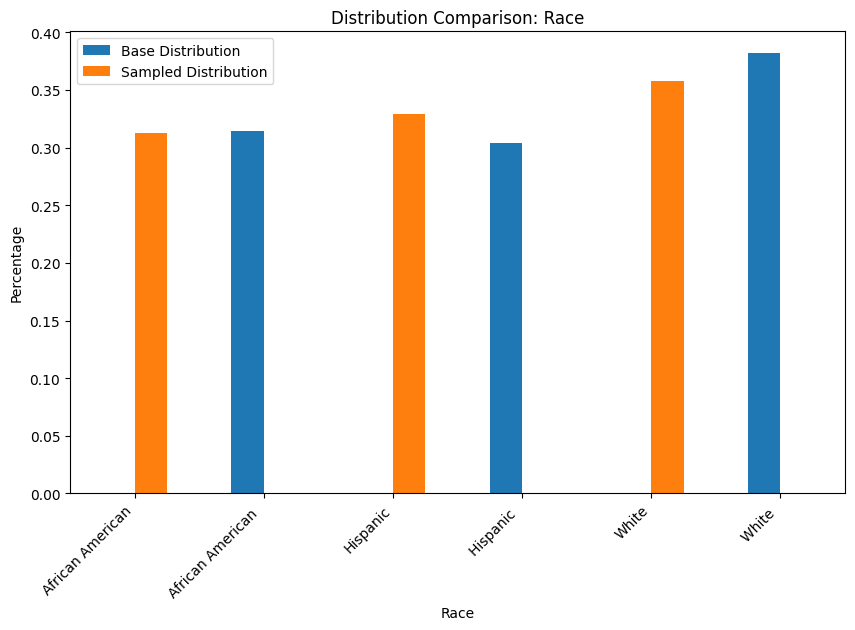

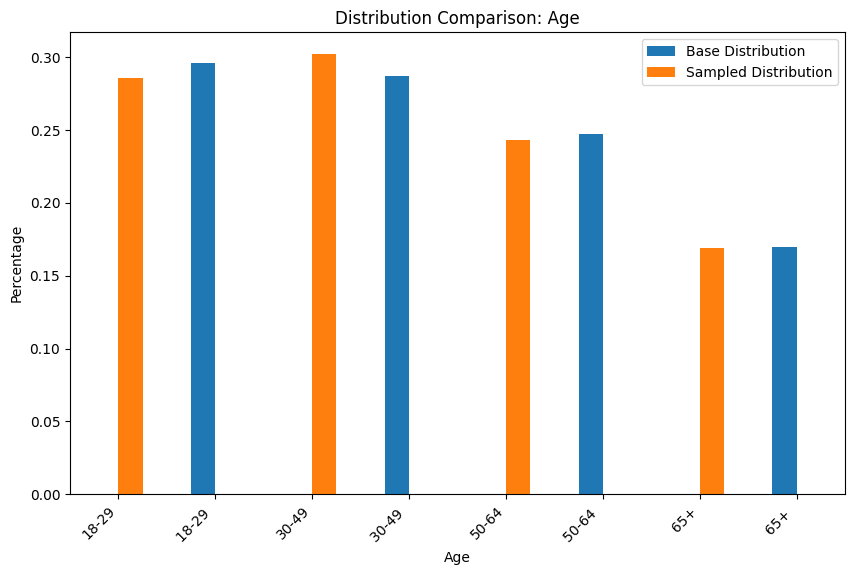

In [24]:
import matplotlib.pyplot as plt

# Generating a population of N=1000 people
population_N_1000 = generate_population(1000)

# Function to plot the distribution comparison
def plot_distribution_comparison(population, base_distribution, category):
    sampled_distribution = population[category].value_counts(normalize=True).sort_index()
    
    comparison_df = pd.DataFrame({
        'Base Distribution': base_distribution / base_distribution.sum(),
        'Sampled Distribution': sampled_distribution
    })

    # Plotting the comparison
    comparison_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Distribution Comparison: {category}')
    plt.ylabel('Percentage')
    plt.xlabel(category)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_distribution_comparison(population_N_1000, race_distribution, 'Race')
#plot_distribution_comparison(population_N_1000, gender_distribution, 'Gender')
plot_distribution_comparison(population_N_1000, age_distribution, 'Age')
#plot_distribution_comparison(population_N_1000, income_distribution, 'Income')
#plot_distribution_comparison(population_N_1000, degree_percentages, 'Degree')
#plot_distribution_comparison(population_N_1000, community_type_percentages, 'Community Type')
#plot_distribution_comparison(population_N_1000, marital_status_percentages, 'Marital Status')

In [17]:
# Save all the paramters of category distributions to an appropriate file so we can read and generate populations easily

import json

parameters = {
    "Race": {
        "White": 51.54,
        "African American": 42.45,
        "Hispanic": 41.09,
    },
    "Gender": {
        "Male": 48.84,
        "Female": 49.18,
    },
    "Age": {
        "18-29": 56.52,
        "30-49": 54.86,
        "50-64": 47.18,
        "65+": 32.46,
    },
    "Income": {
        "Under $20K": 34.40,
        "$20K-$50K": 47.49,
        "$50K-$75K": 56.90,
        "$75K-$100K": 61.60,
        "Over $100K": 62.28,
    },
    "Degree": {
        "Less than HS": 3.37,
        "High School": 13.99,
        "Some College": 22.96,
        "Bachelor's or higher": 59.68,
    },
    "Community Type": {
        "Urban": 36.04,
        "Suburban": 39.34,
        "Rural": 24.62,
    },
    "Marital Status": {
        "Married": 50.43,
        "Living with partner": 7.11,
        "Divorced/Separated": 13.12,
        "Widowed": 5.66,
        "Never married": 23.68,
    },
}

with open('population_parameters.json', 'w') as f:
    json.dump(parameters, f, indent=4)

In [26]:
# now read in the data (population_parameters.json) and use as input to the generate_population function above

with open('population_parameters.json') as f:
    parameters = json.load(f)

# Convert percentages to probabilities
for category, distribution in parameters.items():
    total = sum(distribution.values())
    parameters[category] = {key: value / total for key, value in distribution.items()}

def generate_population(N):
    # Function to sample from a distribution
    def sample_distribution(distribution):
        categories = list(distribution.keys())
        probabilities = list(distribution.values())
        return choice(categories, N, p=probabilities)

    # Sampling from each distribution
    population = {key: sample_distribution(value) for key, value in parameters.items()}

    return pd.DataFrame(population)

# Example of generating a population of 100 individuals
sample_population = generate_population(100)
sample_population[:10]



,Race,Gender,Age,Income,Degree,Community Type,Marital Status
0,Hispanic,Male,30-49,Over $100K,Some College,Urban,Married
1,African American,Male,18-29,$75K-$100K,Bachelor's or higher,Rural,Divorced/Separated
2,White,Male,50-64,$50K-$75K,Bachelor's or higher,Urban,Married
3,White,Male,18-29,$20K-$50K,Bachelor's or higher,Urban,Married
4,White,Female,65+,Over $100K,Bachelor's or higher,Rural,Widowed
5,Hispanic,Female,30-49,Over $100K,Bachelor's or higher,Urban,Married
6,Hispanic,Male,18-29,$75K-$100K,Bachelor's or higher,Suburban,Never married
7,African American,Female,18-29,$75K-$100K,High School,Urban,Widowed
8,White,Female,50-64,$50K-$75K,Bachelor's or higher,Urban,Never married
9,Hispanic,Female,65+,Under $20K,Some College,Suburban,Married
